In [12]:
from rdkit import Chem
import pandas as pd

from rdkit.Chem import Draw, AllChem
from rdkit.Chem import rdMolDescriptors


In [13]:
def clean_smiles(smiles_list):
    cleaned = set()

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue

        # Split into fragments and keep the largest one
        frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
        if not frags:
            continue

        largest = max(frags, key=rdMolDescriptors.CalcExactMolWt)

        try:
            Chem.SanitizeMol(largest)
            canonical = Chem.MolToSmiles(largest, isomericSmiles=True)
            cleaned.add(canonical)
        except:
            continue

    return list(cleaned)

In [14]:
#Import aryl compounds and drimane
aryl = pd.read_csv("Enamine_Orthohalophenol.csv")

aryl_smiles_list = list(aryl.Smiles)

drimane = pd.read_csv("Drimanes.csv")
drimane_smiles_list = list(drimane.Smiles)

## enumerate spirodrimane

In [15]:
aryl_clean_smiles = clean_smiles(aryl_smiles_list)
drimane_clean_smiles = clean_smiles(drimane_smiles_list)
print(len(aryl_clean_smiles))
print(len(drimane_clean_smiles))

858
6


RDKit WARNING: [18:15:19] Conflicting single bond directions around double bond at index 7.
[18:15:19] Conflicting single bond directions around double bond at index 7.
RDKit WARNING: [18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.


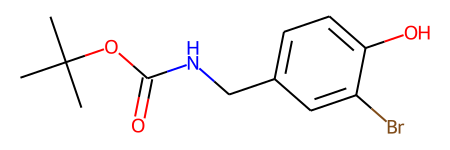

In [16]:
test_aryl = Chem.MolFromSmiles(aryl_clean_smiles[100])
test_drimane = Chem.MolFromSmiles(drimane_clean_smiles[0])
test_aryl


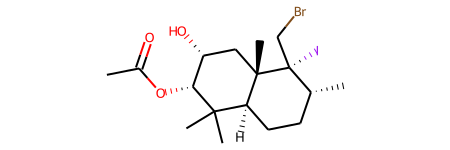

In [17]:
test_drimane

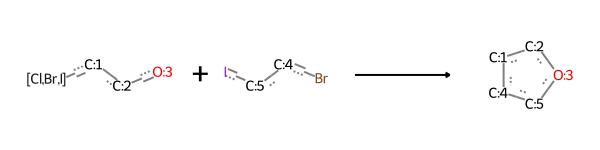

In [18]:
# join the two fragments
make_pdt =  AllChem.ReactionFromSmarts('[Cl,Br,I][cX3:1][cX3:2][O;H1:3].[Br][CX4:4][CX4:5][I]>>[O:3]5[cX3:2][cX3:1][CX4:4][CX4:5]5')
make_pdt


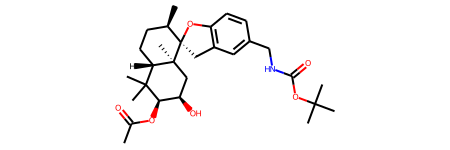

In [19]:
pdt = make_pdt.RunReactants((test_aryl,test_drimane))
pdt[0][0]

In [20]:
final_product_list = []

# Convert SMILES to Mol objects
aryl_mols = [Chem.MolFromSmiles(smi) for smi in aryl_smiles_list if Chem.MolFromSmiles(smi) is not None]
drimane_mols = [Chem.MolFromSmiles(smi) for smi in drimane_smiles_list if Chem.MolFromSmiles(smi) is not None]

# Loop through all aryl × drimane pairs
for aryl_mol in aryl_mols:
    for drimane_mol in drimane_mols:
        try:
            pdt_sets = make_pdt.RunReactants((aryl_mol, drimane_mol))
        except:
            continue  # Skip if reaction fails

        if not pdt_sets:
            continue

        for pdt_set in pdt_sets:
            try:
                Chem.SanitizeMol(pdt_set[0])
                smi = Chem.MolToSmiles(pdt_set[0], isomericSmiles=True)
                final_product_list.append(smi)
            except:
                continue

# Remove duplicates while preserving order
final_product_list = list(dict.fromkeys(final_product_list))


RDKit WARNING: [18:15:19] Conflicting single bond directions around double bond at index 7.
[18:15:19] Conflicting single bond directions around double bond at index 7.
RDKit WARNING: [18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [18:15:19] Conflicting single bond directions around double bond at index 7.
RDKit WARNING: [18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.
[18:15:19] Conflicting single bond directions around double bond at index 7.
[18:15:19]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [21]:
len(final_product_list)

4242

/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


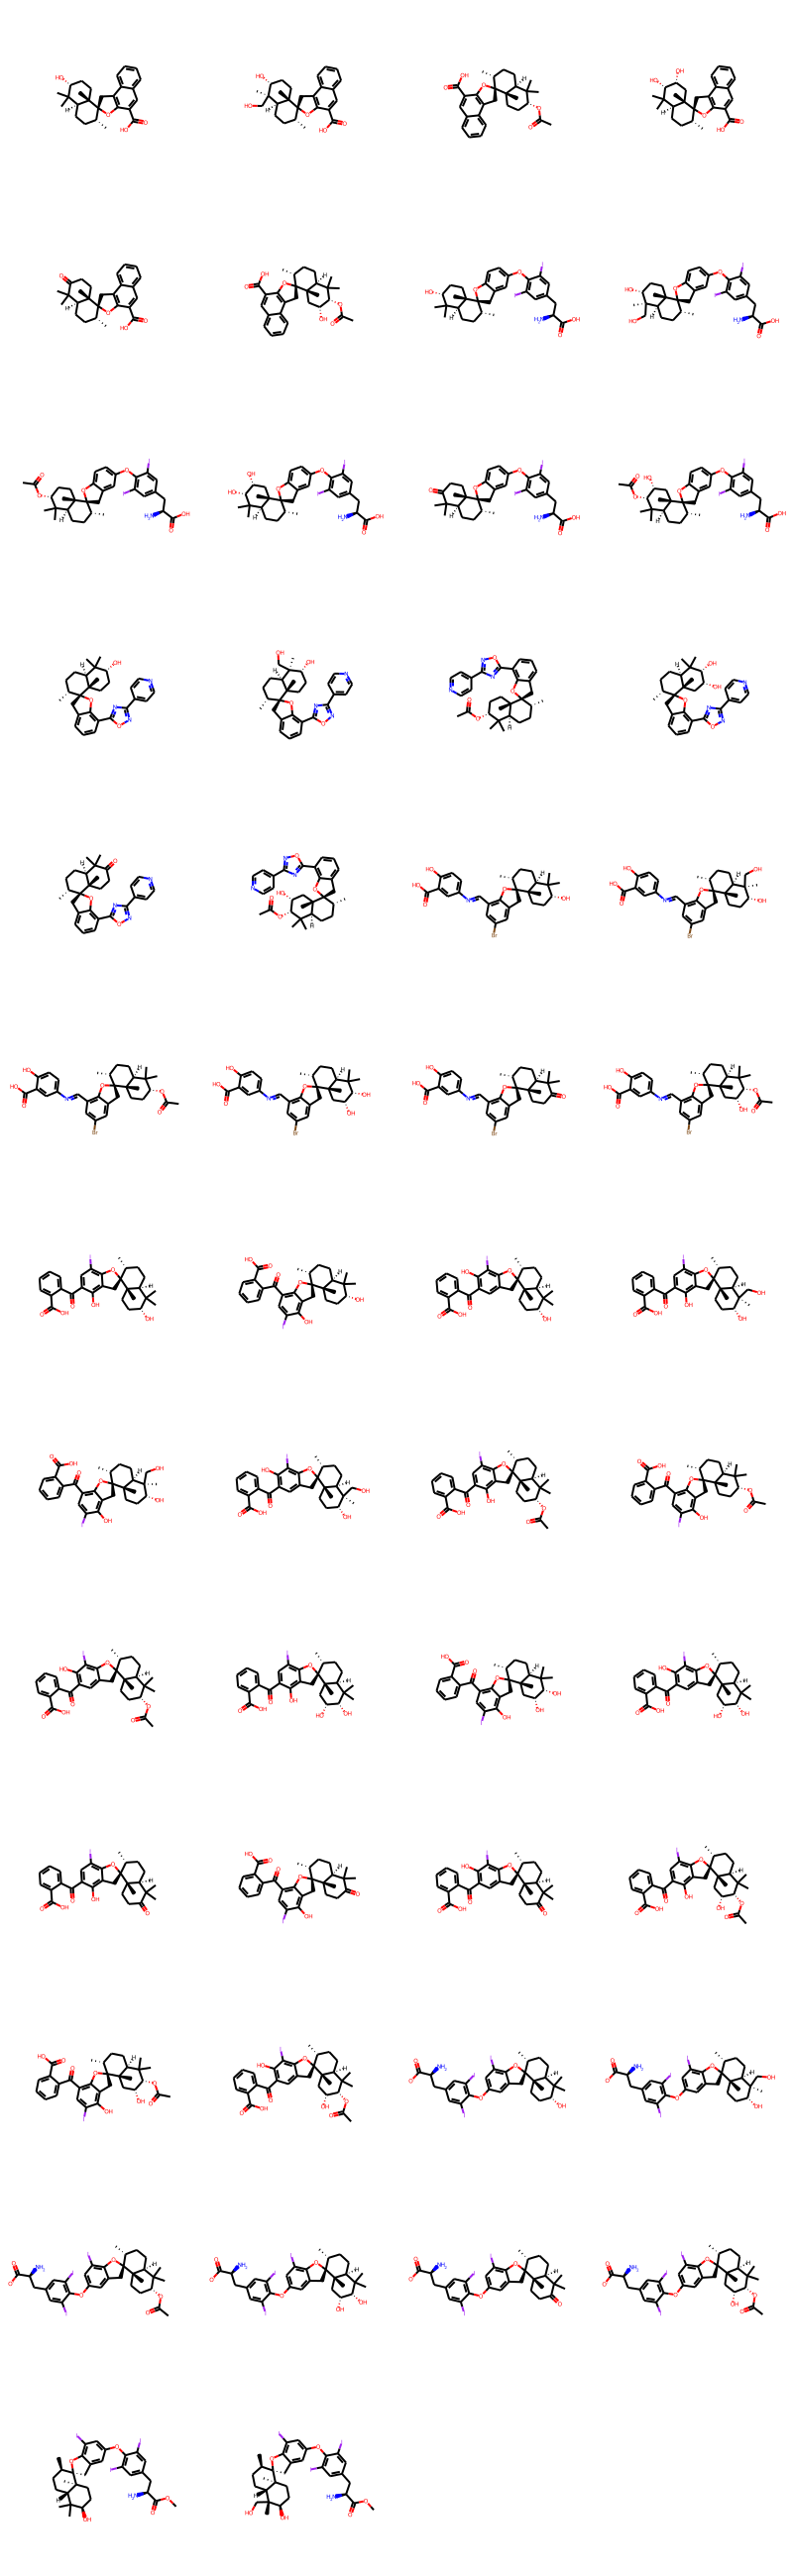

In [22]:
# Convert SMILES strings back into molecules
molecule_list = [Chem.MolFromSmiles(sm) for sm in final_product_list]

# Generate a grid image of the molecules
img = Draw.MolsToGridImage(molecule_list, molsPerRow=4)

# Show the image
img


In [23]:
df = pd.DataFrame({'SMILES': final_product_list})
csv_file_path = 'final_products_Enamine.csv'
df.to_csv(csv_file_path, index=False)